# Grid search for DER++ on Split-CIFAR100

In this notebook we explore a grid search over lr, alpha and beta hyperparameters of DER++, testing on a 10% validation set.

The best combination of hyperparameters is the one having the highest average stream accuracy.

## Imports

In [4]:
import os
from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np

import torch
from torchvision.transforms import Compose, Normalize, ToTensor

from avalanche.benchmarks.classic import SplitCIFAR100

/home/giacomo/mambaforge/envs/continual/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset

I decided to use 10 experiences with 10 new classes each.

We are in a Class-Incremental setting, without task labels.

In [2]:
num_experiences = 10

In [3]:
# Default transformations are the same used in the paper
split_cifar100 = SplitCIFAR100(n_experiences=num_experiences, seed=42, train_transform=Compose([ToTensor(), Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))]))

Files already downloaded and verified
Files already downloaded and verified


## Split training into train and validation

In [4]:
from avalanche.benchmarks.generators import benchmark_with_validation_stream, class_balanced_split_strategy

Split the training set into a training and validation set

In [5]:
validation_size = 0.1
class_balanced_split = lambda exp: class_balanced_split_strategy(validation_size, exp)
split_cifar100_with_valid = benchmark_with_validation_stream(split_cifar100, custom_split_strategy=class_balanced_split, )

In [6]:
print(len(split_cifar100.train_stream[0].dataset))
print(len(split_cifar100.test_stream[0].dataset))

5000
1000


In [7]:
print(len(split_cifar100_with_valid.train_stream[0].dataset))
print(len(split_cifar100_with_valid.valid_stream[0].dataset))
print(len(split_cifar100_with_valid.test_stream[0].dataset))

4500
500
1000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


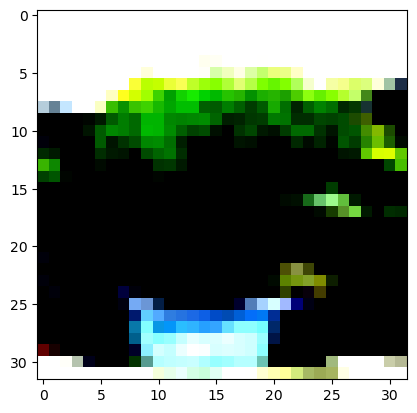

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


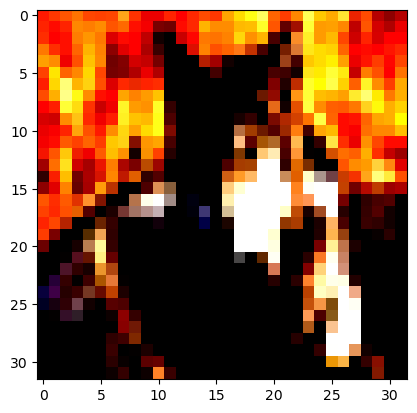

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


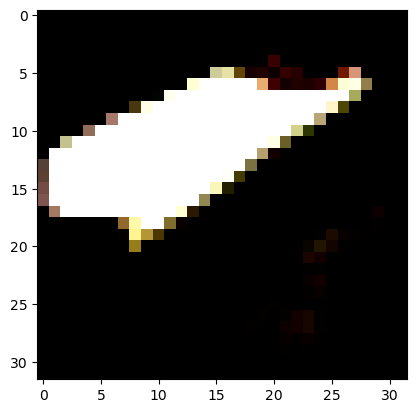

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


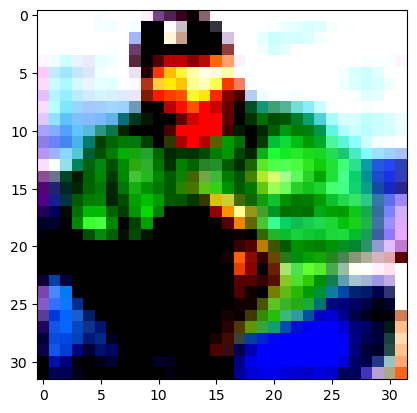

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


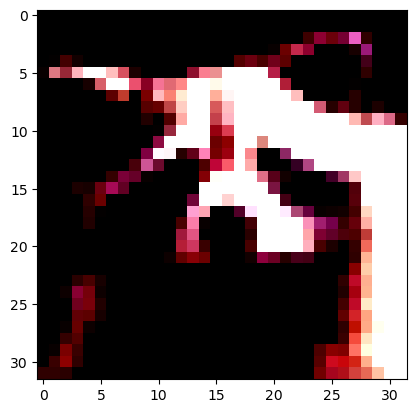

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


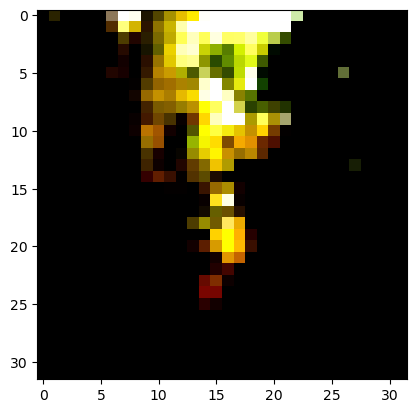

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


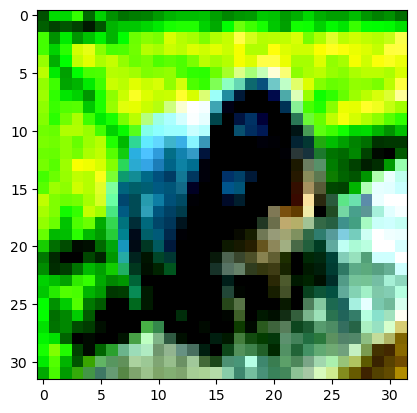

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


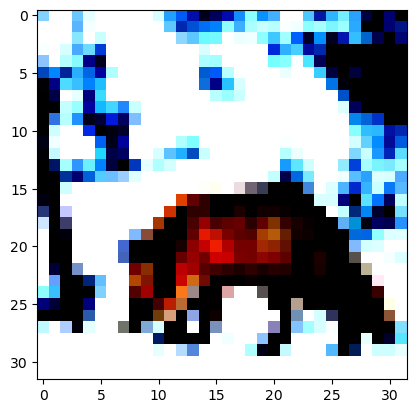

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


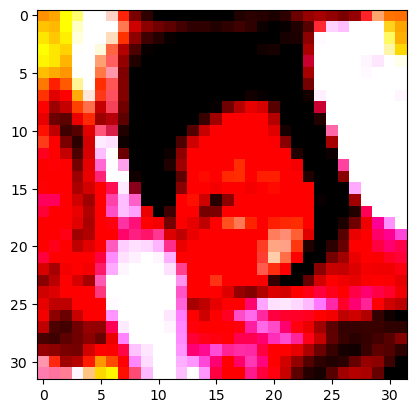

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


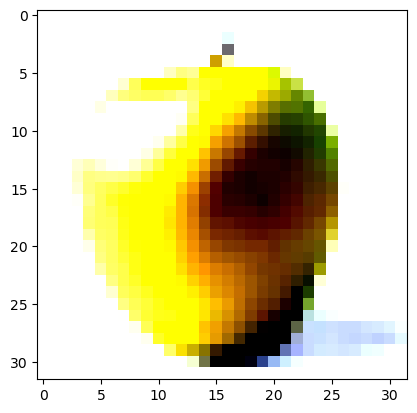

In [8]:
for experience in split_cifar100_with_valid.train_stream:
    # Show the first 4 images in the experience
    for sample in experience.dataset:
        plt.imshow(sample[0].permute(1, 2, 0))
        plt.show()
        break

# Grid Search

In [9]:
from torchvision.models import resnet18
from torch.nn import CrossEntropyLoss
from avalanche.training import Naive

In [10]:
if torch.cuda.is_available():       
        device = torch.device("cuda")
        print(f'There are {torch.cuda.device_count()} GPU(s) available.')
        print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3080 Ti Laptop GPU


In [11]:
from avalanche.training.plugins import EvaluationPlugin
from avalanche.evaluation.metrics import accuracy_metrics, loss_metrics
from avalanche.logging import InteractiveLogger, TextLogger, TensorboardLogger

In [12]:
from der import DerPlugin

### Run with buffer size = 500

In [13]:
# Params

lr_list = [0.3, 0.1, 0.03, 0.01]
alpha_list = [0.2, 0.5, 1.0]
beta_list = [0.0, 0.5, 1.0]

mem_size = 500
epochs = 50
batch_size = 32

In [14]:
eval_plugin = EvaluationPlugin(
    accuracy_metrics(trained_experience=True, stream=True, epoch_running=True),
    loss_metrics(stream=True, epoch_running=True),
    strict_checks=False
)

/home/giacomo/mambaforge/envs/continual/lib/python3.10/site-packages/avalanche/training/plugins/evaluation.py:68: UserWarning: No loggers specified, metrics will not be logged
  warnings.warn("No loggers specified, metrics will not be logged")


In [15]:
for lr in lr_list:
    for alpha in alpha_list:
        for beta in beta_list:
            
            save_pth = f'./grid_search/lr_{lr}_alpha_{alpha}_beta_{beta}.csv'
            # Check if the experiment has already been executed
            if os.path.exists(save_pth):
                continue

            # Create save folder if it doesn't exist
            if not os.path.exists('./grid_search'):
                os.makedirs('./grid_search')
            
            print(f'Executing model with lr: {lr}, alpha: {alpha}, beta: {beta}')

            # Create model, optimizer and criterion
            model = resnet18(weights=None, num_classes=100)
            optimizer = torch.optim.SGD(model.parameters(), lr=lr)
            criterion = CrossEntropyLoss()
            # Initialize DER plugin
            der_plugin = DerPlugin(mem_size=mem_size, alpha=alpha, beta=alpha)
            # Initialize CL strategy
            cl_strategy = Naive(model, optimizer, criterion, train_mb_size=batch_size, train_epochs=epochs, eval_mb_size=batch_size,
                                eval_every=-1, device=device, evaluator=eval_plugin, plugins=[der_plugin])
            
            exp_results = []

            # TRAINING LOOP WITH VALIDATION AT EACH EXPERIENCE
            print('Starting experiment...')
            results = []
            for experience in tqdm(split_cifar100_with_valid.train_stream):
                cl_strategy.train(experience)

                exp_results.append(cl_strategy.eval(split_cifar100_with_valid.valid_stream))

            aggregated_results = {}

            # Aggregate experiencess results by metric
            for i, exp_dict in enumerate(exp_results):
                for metric_name, metric_value in exp_dict.items():
                        if metric_name not in aggregated_results:
                            aggregated_results[metric_name] = []
                            aggregated_results[metric_name].append(metric_value)
                        else:
                            aggregated_results[metric_name].append(metric_value)

            # Save results to csv
            for metric_name, metric_values in aggregated_results.items():
                # write row to csv
                with open(save_pth, 'a') as f:
                    f.write(f'{metric_name},')
                    for value in metric_values:
                        f.write(f'{value},')
                    f.write('\n')

Executing model with lr: 0.01, alpha: 0.5, beta: 0.0
Starting experiment...


100%|██████████| 10/10 [18:55<00:00, 113.50s/it]


Executing model with lr: 0.01, alpha: 0.5, beta: 0.5
Starting experiment...


100%|██████████| 10/10 [18:51<00:00, 113.16s/it]


Executing model with lr: 0.01, alpha: 0.5, beta: 1.0
Starting experiment...


100%|██████████| 10/10 [18:10<00:00, 109.03s/it]


Executing model with lr: 0.01, alpha: 1.0, beta: 0.0
Starting experiment...


100%|██████████| 10/10 [18:32<00:00, 111.25s/it]


Executing model with lr: 0.01, alpha: 1.0, beta: 0.5
Starting experiment...


100%|██████████| 10/10 [19:06<00:00, 114.68s/it]


Executing model with lr: 0.01, alpha: 1.0, beta: 1.0
Starting experiment...


100%|██████████| 10/10 [17:54<00:00, 107.42s/it]


### Analysis

In [1]:
import pandas as pd
import glob
import seaborn as sns

Average stream accuracy is the chosen metric for evaluating the grid search results.

In [2]:
all_files = glob.glob('./grid_search/*.csv')

# Save accuracies after trained experience for each experience of the grid search runs.
# In the dict the key is the grid search run, while the value is a list of accuracies after each experience
acc_trained_exps_dict = {}

for file in all_files:
    df = pd.read_csv(file, index_col=None, header=None)
    acc_trained_exps = df[df[0].str.startswith('Accuracy_On_Trained_Experiences/eval_phase/valid_stream/Task000')].values[0][1:-1]
    # Get the filename without the path and the extension
    filename = file.split('/')[-1].split('.csv')[0]

    acc_trained_exps_dict[filename] = acc_trained_exps

# Get the average accuracy after all experiences
avg_acc_dict = {}
for key, value in acc_trained_exps_dict.items():
    avg_acc_dict[key] = acc_trained_exps_dict[key][-1]


Create a heathmap of alpha and beta average accuracy for each lr value.

In [5]:
lr_list = ['0.3', '0.1', '0.03', '0.01']
alpha_list = ['0.2', '0.5', '1.0']
beta_list = ['0.0', '0.5', '1.0']

# Create a metrix of accuraccies for each lr
acc_matrix_dict = {}

for lr in lr_list:
    acc_matrix_dict[lr] = np.zeros((len(alpha_list), len(beta_list)))

for lr in lr_list:
    for i, alpha in enumerate(alpha_list):
        for j, beta in enumerate(beta_list):
            acc_matrix_dict[lr][i, j] = avg_acc_dict['lr_'+lr+'_alpha_'+alpha+'_beta_'+beta]

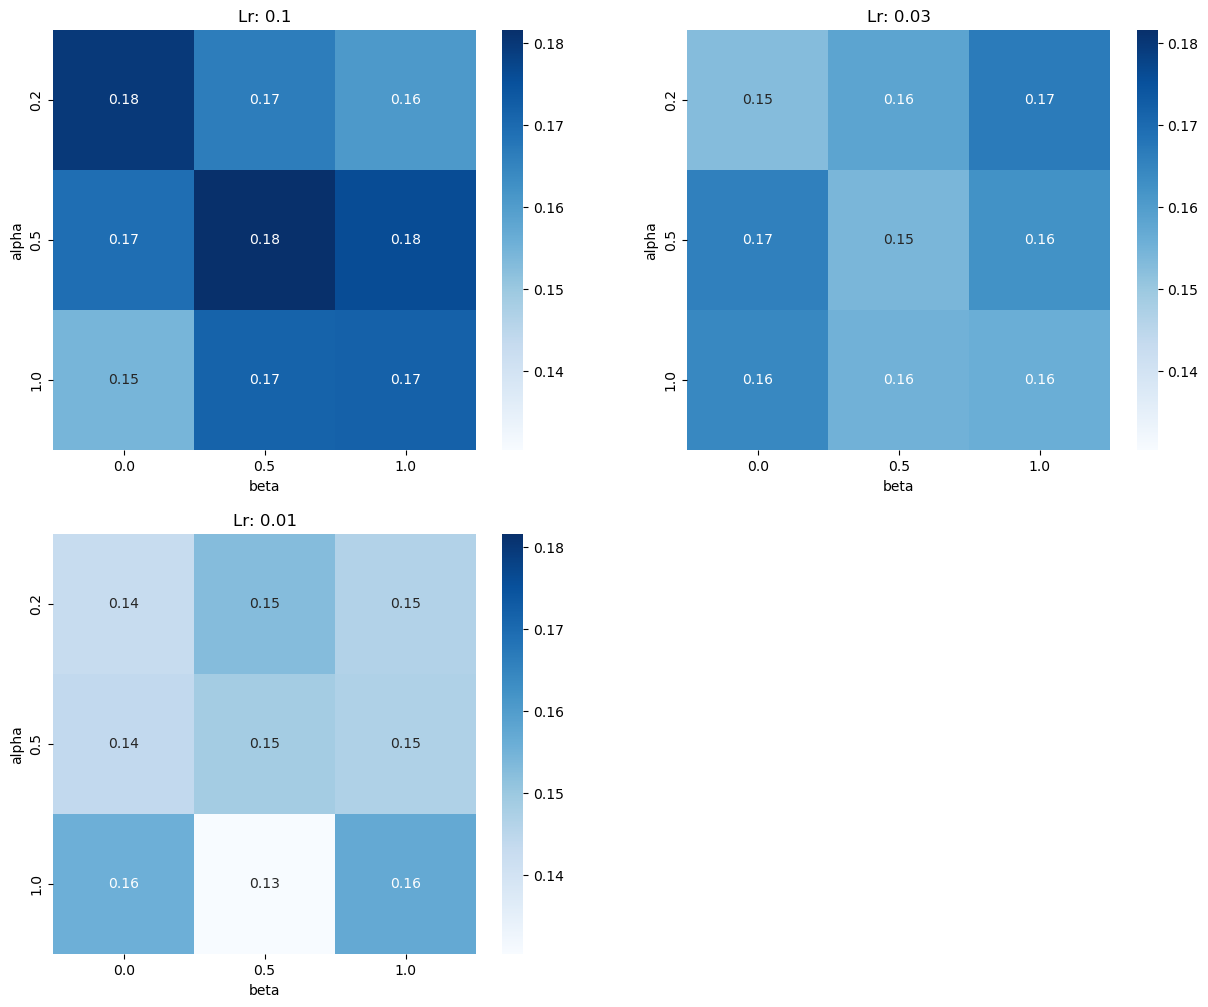

In [26]:
min_acc = min(avg_acc_dict.values())
max_acc = max(avg_acc_dict.values())

# Show the heathmaps
plt.figure(figsize=(15, 12))
for i, (lr, acc_matrix) in enumerate(acc_matrix_dict.items()):
    plt.subplot(2,2,i+1)
    sns.heatmap(acc_matrix, annot=True, vmin=min_acc, vmax=max_acc, cmap='Blues', xticklabels=beta_list, yticklabels=alpha_list)
    plt.xlabel('beta')
    plt.ylabel('alpha')
    plt.title(f'Lr: {lr}')
    

plt.show()
